## Interface to statsmodels: ARIMAX and state space time series models

This notebook provides a short exposition of how it is possible to interface with the cornucopia of time series models provided by the [statsmodels](https://www.statsmodels.org/stable/index.html) package. In this notebook, we illustrate how to fit the logistic ODE model, where the errors are described by ARIMAX and state space models.

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

## ARMA errors

We assume that the observed data $y(t)$ follows

$$y(t)= f(t; \theta) + \epsilon(t).$$

Under the ARMA(1,1) noise model, the error terms $\epsilon(t)$ have 1 moving average term and 1 autoregressive term. Therefore, 

$$\epsilon(t) = \rho \epsilon(t-1) + \nu(t) + \phi \nu(t-1),$$

where the white noise term $\nu(t) \overset{i.i.d.}{\sim} \mathcal{N}(0, \sigma \sqrt{(1 - \rho^2) / (1 + 2 \rho \phi + \phi^2))}$. The noise process standard deviation is such that the marginal distribution of $\epsilon$ is,

$$\epsilon\sim\mathcal{N}(0, \sigma).$$

The ARMA(1,1) noise model is available in Pints using `pints.ARMA11LogLikelihood`. As before, the code below shows how to generate a time series with ARMA(1,1) noise and perform Bayesian inference using the Kalman filter provided by the statsmodels ARIMA module.

Note that, whilst we do not show how to do this, it would be possible to use the `score` function of the [statsmodels](https://www.statsmodels.org/stable/index.html) package, to calculate sensitivities of the log-likelihood.

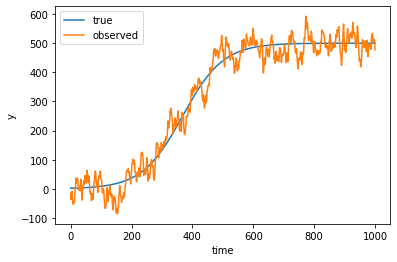

In [2]:
# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 40
rho = 0.9
phi = 0.95
errors = pints.noise.arma11(rho, phi, noise, len(org_values))
values = org_values + errors

# Show the noisy data
plt.figure()
plt.plot(times, org_values)
plt.plot(times, values)
plt.xlabel('time')
plt.ylabel('y')
plt.legend(['true', 'observed'])
plt.show()

## Fit model using statsmodels' ARIMA Kalman filter

Here, we fit an ARMA(1,1) model.

Running...
Done!


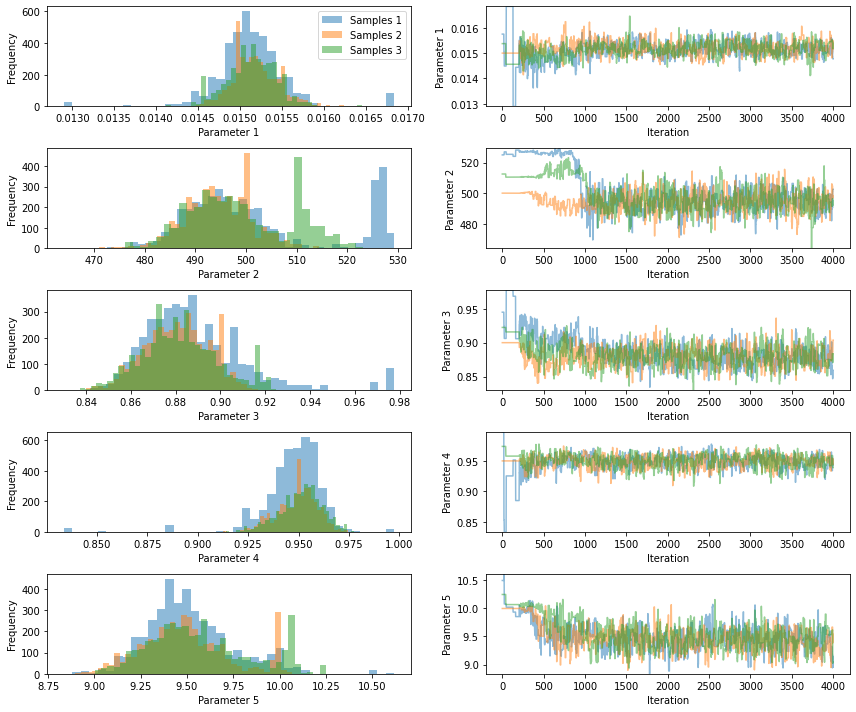

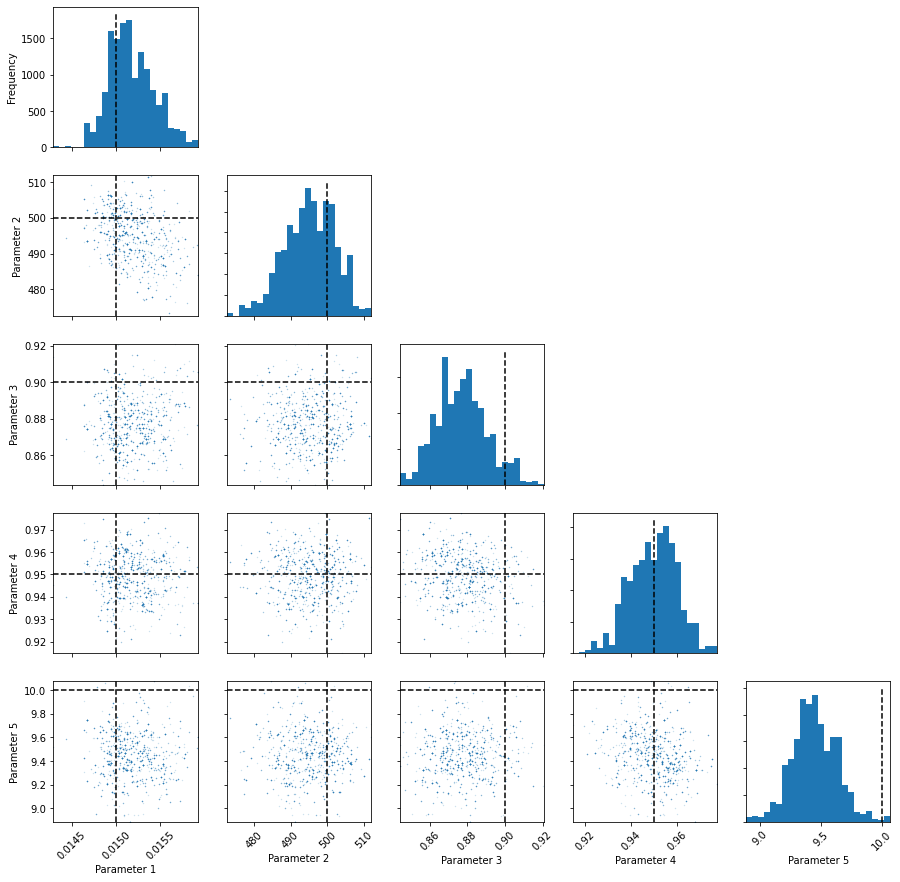

In [3]:
from statsmodels.tsa.arima.model import ARIMA

model = toy.LogisticModel()

class ARIMALogLikelihood(pints.ProblemLogLikelihood):
    def __init__(self, problem, arima_order):
        super(ARIMALogLikelihood, self).__init__(problem)
        self._nt = len(self._times) - 1
        self._no = problem.n_outputs()
        
        if len(arima_order) != 3:
            raise ValueError("ARIMA (p, d, q) orders must be tuple of length 3.")
        self._arima_order = arima_order
        p = arima_order[0]
        d = arima_order[1]
        q = arima_order[2]
        self._p = p
        self._q = q
        self._d = d
        
        self._n_parameters = problem.n_parameters() + (p + q + 1) * self._no
    
    def __call__(self, x):
        x = x.tolist()
        m = (self._p + self._q + 1) * self._no
        parameters = x[-m:]
        sol = self._problem.evaluate(x[:-m])
        model = ARIMA(endog=self._values,
                      order=self._arima_order,
                      exog=sol)
        # first param is trend (if model not differenced),
        # second is coefficient on ODE soln
        # see model.param_names
        sigma2 = parameters[-1]**2
        parameters = parameters[:-1] + [sigma2]
        if self._d == 0:
            full_params = [0, 1] + parameters
        else:
            full_params = [1] + parameters 
        return model.loglike(full_params)
    
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = ARIMALogLikelihood(problem, arima_order=(1, 0, 1))

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, 0, 0, noise * 0.1],
    [0.02, 600, 1, 1, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters = np.array(real_parameters + [rho, phi, 10])
xs = [
    real_parameters * 1.05,
    real_parameters * 1,
    real_parameters * 1.025
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=False, ref_parameters=real_parameters)

# Show graphs
plt.show()

Look at results. Note that 'sigma' will be different to the value used to generate the data, due to a different definition.

In [4]:
results = pints.MCMCSummary(chains=chains,
                            parameter_names=['r', 'k', 'rho', 'phi', 'sigma'])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------
r        0.02    0.00    0.01    0.02    0.02    0.02    0.02     1.01    327.32
k        494.75  7.00    480.91  489.78  494.73  499.45  508.21   1.00    328.94
rho      0.88    0.01    0.85    0.87    0.88    0.89    0.91     1.01    370.48
phi      0.95    0.01    0.93    0.94    0.95    0.96    0.97     1.01    357.56
sigma    9.44    0.18    9.08    9.32    9.43    9.57    9.80     1.02    342.25


# Fitting a local level state space model

We assume that the observed data $y(t)$ follows

$$y(t)= f(t; \theta) + \epsilon(t).$$

Where the errors follow a local level model:

$$\epsilon(t) = \mu(t) + \nu(t),$$
$$\mu(t) = \mu(t-1) + \eta(t),$$

as described [here](https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents) (also see this link for a description of the huge family of state space models available in this package). The two parameters of the error process are the variances of $\nu(t)$ and $\eta(t)$ respectively.

In [5]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

We first generate some local level noise and overlay on the ODE. Note that this noise is non-stationary, so the observed data can drift away from the actual solution for long periods.

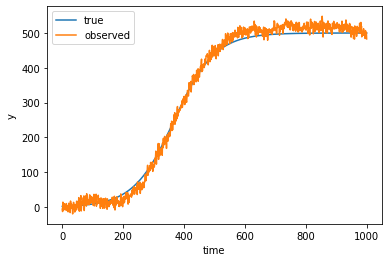

In [6]:
import scipy.stats
def local_level(n, sigma1, sigma2):
    nu = scipy.stats.norm.rvs(0, sigma1, n)
    eta = scipy.stats.norm.rvs(0, sigma2, n)
    y = np.zeros(n)
    mu = np.zeros(n)
    mu[0] = eta[0]
    for i in range(1, n):
        mu[i] = mu[i - 1] + eta[i]
    for i in range(n):
        y[i] = mu[i] + nu[i]
    return y


errors = local_level(len(org_values), 10, 1)
values = org_values + errors

# Show the noisy data
plt.figure()
plt.plot(times, org_values)
plt.plot(times, values)
plt.xlabel('time')
plt.ylabel('y')
plt.legend(['true', 'observed'])
plt.show()

Note, that when wrapping the various models in this package into Pints, a useful function is the `model.param_names` function that provides a description of these parameters. We illustrate this below: note that `beta.x1` is the coefficient on the ODE solution, so needs to be supplied as '1' in the wrapper we show later.

In [7]:
sol = problem.evaluate([0.15, 500])
model = UnobservedComponents(endog=problem.values(), level='llevel', exog=sol)
model.param_names

['sigma2.irregular', 'sigma2.level', 'beta.x1']

Wrapping the a state space model in a Pints log-likelihood. Here, `ss_model` is a string corresponding to the list of prebuilt state space models [here](https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents); `ss_n_params` is the number of parameters that the particular time series model involves.

In [8]:
class StateSpaceLogLikelihood(pints.ProblemLogLikelihood):
    def __init__(self, problem, ss_model, ss_n_params):
        super(StateSpaceLogLikelihood, self).__init__(problem)
        self._nt = len(self._times) - 1
        self._no = problem.n_outputs()
        self._ss_model = ss_model
        self._ss_n_params = ss_n_params
        self._n_parameters = problem.n_parameters() + ss_n_params * self._no
    
    def __call__(self, x):
        x = x.tolist()
        m = self._ss_n_params * self._no
        parameters = x[-m:]
        sol = self._problem.evaluate(x[:-m])
        model = UnobservedComponents(endog=problem.values(),
                                     level=self._ss_model, exog=sol)
        return model.loglike(parameters + [1])

Instantiate the model, log-posterior etc., then run MCMC.

In [9]:
model = toy.LogisticModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = StateSpaceLogLikelihood(problem, 'llevel', 2)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.00, 400, 0, 0],
    [0.05, 600, 3000, 3000],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters = np.array([0.015, 500] + [100, 1])
xs = [
    real_parameters * 1.05,
    real_parameters * 1,
    real_parameters * 1.025
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


Show traces.

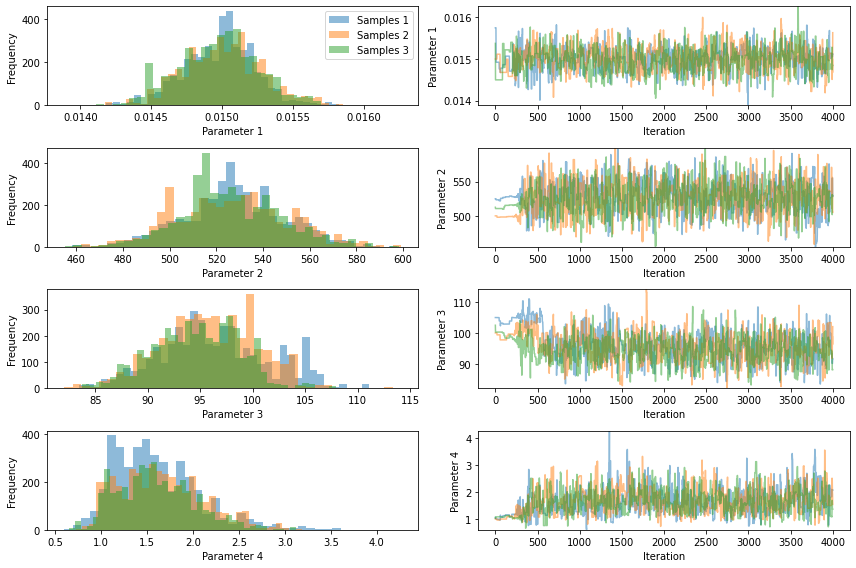

In [10]:
pints.plot.trace(chains)
plt.show()

Look at summary stats: all parameters look similar to their true values.

In [11]:
results = pints.MCMCSummary(chains=chains, 
                            parameter_names=['r', 'k', 'sigma2_nu', 'sigma2_eta'])
print(results)

param       mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess
----------  ------  ------  ------  ------  ------  ------  -------  ------  ------
r           0.01    0.00    0.01    0.01    0.02    0.02    0.02     1.01    742.69
k           526.63  22.37   483.37  512.21  526.46  541.11  572.11   1.01    589.99
sigma2_nu   95.69   4.71    86.90   92.48   95.46   98.88   104.99   1.05    321.72
sigma2_eta  1.62    0.45    0.96    1.26    1.57    1.90    2.61     1.02    159.28
